In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../")

In [3]:
from data_processing.start_experiment import *
from data_processing.read_data import *
from data_processing.gaussian import *

In [4]:
num_experiments = 100
parameter_list = ['gamma', 'gradnoise']

In [5]:
file_names = ["gradient_latin/latin_{}.par".format(i) for i in range(num_experiments)]
data_files = ["gradient_latin/data_cellcount_{}.txt".format(i) for i in range(num_experiments)]

In [6]:
X = get_parameter_array(file_names,parameter_list)

In [7]:
print(X[0])

[20.      0.6015]


In [8]:
# ts_dist_Y = get_timestep_rewards(data_files[97], function_at_each_timestep(average_angle_diff_to_peak))

# ts_d_peak = get_timestep_rewards(data_files[97], function_at_each_timestep(distance_to_peak_gradient))

# ts_d_migration = get_timestep_rewards(data_files[97], function_at_each_timestep(average_angle_migration_to_peak))

# # print(ts_dist_Y)
# # print(ts_d_migration)
# # print(ts_d_peak)
print(get_timestep_rewards(data_files[0], function_at_each_timestep(distance_to_peak_gradient)))


[247.76864588 246.68638358 244.40435479 243.57152699 244.57849078
 243.85263311 243.45312342 240.5125975  238.34505873 236.90582546
 232.78352551 229.48591675 226.75246363 227.12951095 228.28638326
 229.58473155 229.91019362 227.74453888 224.27773398 223.89449088
 222.99556753 220.59621473 216.89718401 215.22148163 215.54175375
 216.39969598 216.42531291 214.05196614 216.63486634 215.31503037
 214.86931278 212.91184627 211.61141771 211.45267076 211.56421506
 212.70504248 214.48815545 212.19939735 206.93221251 205.16401804
 204.09421297 203.37175625 201.93624177 200.43398251 203.51799526
 201.63548281 202.0727117  199.86032614 197.45160983 198.11814208
 200.0157936 ]


In [9]:
# split data files for test 
train_data = data_files[:90]
test_data = data_files[90:-1]

In [10]:
print(test_data[0])
print(train_data[-1])

gradient_latin/data_cellcount_90.txt
gradient_latin/data_cellcount_89.txt


In [11]:
# param space
# use input params grad noise and gamma (constant across single seasons)
# use angle difference
# use migration difference
# use stepwise speed (TODO)
# use distance difference 
# distance between cells

In [12]:
# print(X)

In [13]:
# Emulate distance first
simulation_samples_X = np.empty(shape=[0, 6])
simulation_samples_Y = np.empty(shape=[0, 1])
for i in range(len(train_data)):
    
    # x_params = get_parameter_array(train_data[i], parameter_list)
    
    migration_angle_dif = np.array(get_timestep_rewards(data_files[i], function_at_each_timestep(average_angle_migration_to_peak)))
    chemo_angle_dif = np.array(get_timestep_rewards(data_files[i], function_at_each_timestep(average_angle_diff_to_peak)))
    distance_dif = np.array(get_timestep_rewards(data_files[i], function_at_each_timestep(distance_to_peak_gradient)))
    dist_cells = np.array(get_timestep_rewards(data_files[i], function_at_each_timestep(average_distance_between_cells)))

    # indeces
    index = np.linspace(0, len(distance_dif)-2,int(len(distance_dif)/2), dtype=int)
    reward_index = index + 1


    migration_x = migration_angle_dif[index]
    chemo_angle_x = chemo_angle_dif[index]
    distance_x = distance_dif[index]
    dist_cells_x = dist_cells[index]


    distance_y = distance_dif[reward_index]

    for j in range(len(index)):
        sim_X = [migration_x[j], chemo_angle_x[j], distance_x[j], dist_cells_x[j], X[i][0], X[i][1]]
        simulation_samples_X = np.vstack([simulation_samples_X, sim_X]) 
        sim_Y = [distance_y[j]]
        simulation_samples_Y = np.vstack([simulation_samples_Y, sim_Y])

    

In [14]:
# print(simulation_samples_Y)
# print(simulation_samples_X)

In [15]:
print(simulation_samples_X.shape)
print(simulation_samples_Y.shape)

# simulation_samples_Y /= np.std(simulation_samples_Y, axis=0)
# print(simulation_samples_Y)

(2143, 6)
(2143, 1)


In [29]:
from GPy.models import GPRegression

kernel_mattern = GPy.kern.Matern52(6, variance = 1., ARD=True)
sim_y_noise = simulation_samples_Y.var()*0.01



In [33]:
distance_model = GPRegression(simulation_samples_X, simulation_samples_Y, kernel = kernel_mattern.copy(), noise_var=sim_y_noise) 
# distance_model.Gaussian_noise.constrain_fixed(50, warning=False)

In [18]:
# # takes a long time
# distance_model.optimize()

In [34]:
def get_file_test_data(idx):

    test_X = np.empty(shape=[0, 6])
    test_Y = np.empty(shape=[0, 1])

    migration_angle_dif = np.array(get_timestep_rewards(data_files[idx+90], function_at_each_timestep(average_angle_migration_to_peak)))
    chemo_angle_dif = np.array(get_timestep_rewards(data_files[idx+90], function_at_each_timestep(average_angle_diff_to_peak)))
    distance_dif = np.array(get_timestep_rewards(data_files[idx+90], function_at_each_timestep(distance_to_peak_gradient)))
    dist_cells = np.array(get_timestep_rewards(data_files[idx+90], function_at_each_timestep(average_distance_between_cells)))

    # indeces
    index = np.linspace(0, len(distance_dif)-2,int(len(distance_dif)), dtype=int)
    # reward_index = index + 1
    reward_index = index +1 

    migration_x = migration_angle_dif[index]
    chemo_angle_x = chemo_angle_dif[index]
    distance_x = distance_dif[index]
    dist_cells_x = dist_cells[index]


    distance_y = distance_dif[reward_index]

    for j in range(len(index)):
        sim_X = [migration_x[j], chemo_angle_x[j], distance_x[j], dist_cells_x[j], X[idx+90][0], X[idx+90][1]]
        test_X = np.vstack([test_X, sim_X]) 
        sim_Y = [distance_y[j]]
        test_Y = np.vstack([test_Y, sim_Y])

    return test_X, test_Y


In [38]:

test_X, test_Y = get_file_test_data(7)
mean_, var_ = distance_model.predict(test_X)


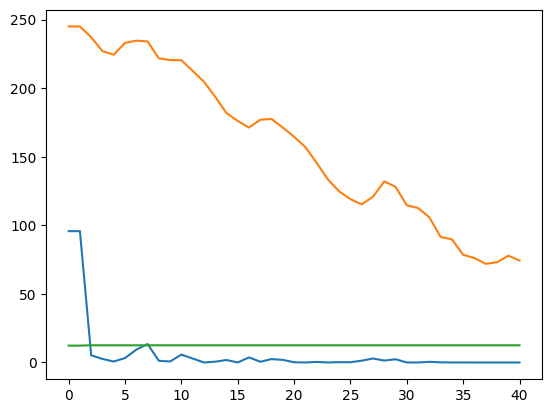

In [39]:
import matplotlib.pyplot as plt
plt.plot(mean_)
plt.plot(test_Y)
plt.plot(var_)